# Prueba técnica
## Renato García Morán
### Clasificación por transfer learning  
**Implementación con TensorFlow**  
* Modelo pre-entrenado utilizado: https://www.kaggle.com/models/google/mobilenet-v2  
* Dataset utilizado: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset  
* Precisión obtenida: 93%
* Etiquetas: Covid, Viral Pneumonia, Normal

In [73]:
#@title Instalacion de tf_keras
# !pip install tf_keras

In [74]:
#@title Importaciones necesarias
import tensorflow as tf
import tf_keras as tfk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import tensorflow_hub as hub
import os
import glob
import cv2
import numpy as np
import random

In [75]:
#@title Preparación del dataset
# https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
#! unzip archive.zip

In [76]:
#@title Definición del dataset
paths = [
    "Covid19-dataset/train/",
    "Covid19-dataset/test/"
]

In [77]:
#@title Definición de las tres etiquetas
possible_labels=os.listdir(paths[0])
possible_labels

['Normal', 'Viral Pneumonia', 'Covid']

In [78]:
#@title Carga de las imágenes ajustando las dimensiones
data = []

for i, path in enumerate(paths):
    for label_int, label_string in enumerate(possible_labels):
        filenames = glob.glob(path + label_string + "/*.jpg") + glob.glob(path + label_string + "/*.jpeg") + glob.glob(path + label_string + "/*.png")
        for filename in filenames:
            img = cv2.imread(filename)
            data.append([label_int, cv2.resize(img, (224, 224)), filename])
len(data)
random.Random(0).shuffle(data)

In [79]:
#@title Separación

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

# Separar los datos en entrenamiento, validación y prueba
for i, sample in enumerate(data):
    label = sample[0]
    img = sample[1]
    img_path = sample[2]  # Ruta de la imagen

    if i <= 0.8 * len(data):
        x_train.append(img)
        y_train.append(label)

    elif i > 0.8 * len(data) and i <= 0.9 * len(data):
        x_val.append(img)
        y_val.append(label)

    else:
        x_test.append(img)
        y_test.append(label)
        print(f"Imagen asignada a test: {img_path}")

x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Imagen asignada a test: Covid19-dataset/train/Viral Pneumonia/096.jpeg
Imagen asignada a test: Covid19-dataset/train/Covid/076.jpg
Imagen asignada a test: Covid19-dataset/train/Covid/058.jpeg
Imagen asignada a test: Covid19-dataset/train/Covid/COVID-00020.jpg
Imagen asignada a test: Covid19-dataset/train/Normal/071.jpeg
Imagen asignada a test: Covid19-dataset/test/Viral Pneumonia/0112.jpeg
Imagen asignada a test: Covid19-dataset/train/Covid/065.jpeg
Imagen asignada a test: Covid19-dataset/train/Covid/COVID-00010.jpg
Imagen asignada a test: Covid19-dataset/train/Normal/012.jpeg
Imagen asignada a test: Covid19-dataset/train/Normal/06.jpeg
Imagen asignada a test: Covid19-dataset/train/Covid/091.jpg
Imagen asignada a test: Covid19-dataset/train/Viral Pneumonia/024.jpeg
Imagen asignada a test: Covid19-dataset/test/Viral Pneumonia/0109.jpeg
Imagen asignada a test: Covid19-dataset/train/Viral Pneumonia/021.jpeg
Imagen asignada a test: Covid19-dataset/train/Normal/094.jpeg
Imagen asignada a te

In [80]:
#@title Definición del modelo preentrenado
import kagglehub

path_model = kagglehub.model_download("google/mobilenet-v2/tensorFlow2/100-224-feature-vector")

In [81]:
#@title Definicion de la estructura de la red
def transferLearning_model():
    model = tfk.Sequential()
    model.add(hub.KerasLayer(path_model, trainable=False))  # Modelo preentrenado
    model.add(tfk.layers.Dense(30, activation='relu'))
    model.add(tfk.layers.Dense(3, activation='softmax'))  # Tenemos 3 clases
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
    model.build([None, 224, 224, 3])  # Definimos las dimensiones de la imagen en forma de tensor
    return model

Creamos la estructura de la red neuronal, con la diferencia de que añadimos el modelo entrenado como si fuera una capa más en lugar de añadir capas de convolución y definimos que no queremos dejar fijos sus parámetros.

In [82]:
#@title Inicializamos el modelo
model = transferLearning_model()

In [83]:
#@title Listamos las caracteristicas
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_6 (Dense)             (None, 30)                38430     
                                                                 
 dense_7 (Dense)             (None, 3)                 93        
                                                                 
Total params: 2296507 (8.76 MB)
Trainable params: 38523 (150.48 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Tenemos 1280 features

In [84]:
y_trainOneHot=tf.one_hot(y_train,len(possible_labels))
y_valOneHot=tf.one_hot(y_val,len(possible_labels))
y_testOneHot=tf.one_hot(y_test,len(possible_labels))

In [85]:
history = model.fit(x_train,
          y_trainOneHot,
          epochs=40,
          batch_size=100,
          validation_data=(x_val,y_valOneHot),
          )

Epoch 1/40
3/3 [==============================] - 4s 405ms/step - loss: 1.2982 - accuracy: 0.3583 - val_loss: 1.7977 - val_accuracy: 0.3750
Epoch 2/40
3/3 [==============================] - 0s 124ms/step - loss: 1.5620 - accuracy: 0.3622 - val_loss: 1.0424 - val_accuracy: 0.5000
Epoch 3/40
3/3 [==============================] - 0s 108ms/step - loss: 0.9638 - accuracy: 0.4764 - val_loss: 0.9845 - val_accuracy: 0.4375
Epoch 4/40
3/3 [==============================] - 0s 108ms/step - loss: 0.8326 - accuracy: 0.6378 - val_loss: 0.8920 - val_accuracy: 0.6250
Epoch 5/40
3/3 [==============================] - 0s 111ms/step - loss: 0.7853 - accuracy: 0.7244 - val_loss: 0.9470 - val_accuracy: 0.5625
Epoch 6/40
3/3 [==============================] - 0s 123ms/step - loss: 0.9159 - accuracy: 0.5512 - val_loss: 0.8397 - val_accuracy: 0.6562
Epoch 7/40
3/3 [==============================] - 0s 112ms/step - loss: 0.7189 - accuracy: 0.7244 - val_loss: 1.0423 - val_accuracy: 0.4375
Epoch 8/40
3/3 [====

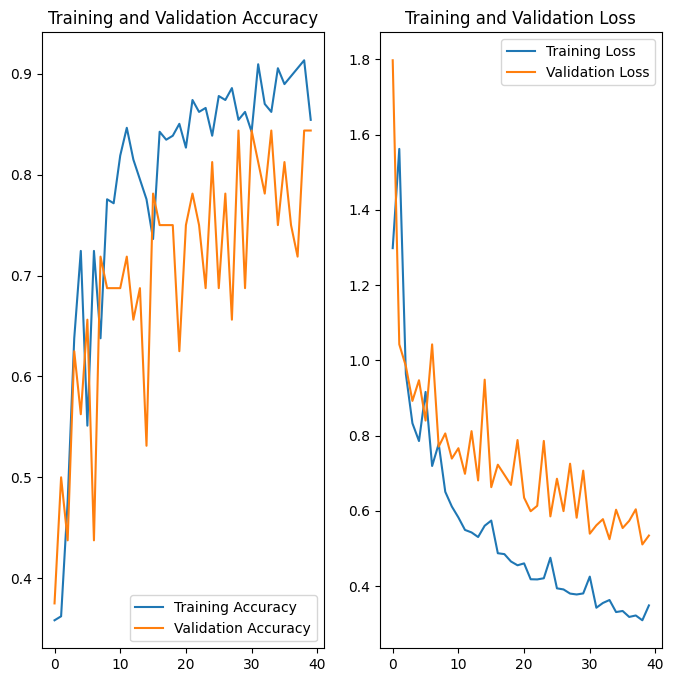

In [86]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [99]:
#@title Test individual imagen pneumonia
img_height, img_width = 224, 224
class_names = ['COVID-19', 'pneumonia', 'normal']

img_path = "Covid19-dataset/train/Viral Pneumonia/033.jpeg"

img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

for i, class_name in enumerate(class_names):
    print("La imagen tiene una probabilidad de {:.2f}% de ser {}".format(100 * score[i], class_name))

print(
    "Esta imagen probablemente pertenece a {} con una confianza del {:.2f}%."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 61ms/step
La imagen tiene una probabilidad de 22.56% de ser COVID-19
La imagen tiene una probabilidad de 55.55% de ser pneumonia
La imagen tiene una probabilidad de 21.88% de ser normal
Esta imagen probablemente pertenece a pneumonia con una confianza del 55.55%.


In [101]:
#@title Evaluamos el modelo con las imagenes de prueba para ver la efectividad
model.evaluate(x=x_test,y=y_testOneHot)

1/1 [==============================] - 0s 70ms/step - loss: 0.3708 - accuracy: 0.9355


[0.370831698179245, 0.9354838728904724]

In [107]:
#@title Guardamos el modelo
model.save('model.keras')

In [102]:
predicciones = model.predict(x_test)

1/1 [==============================] - 0s 22ms/step


Distribución de etiquetas en el conjunto de prueba: {0: 7, 1: 8, 2: 16}
Imagen 0: Predicción -> Viral Pneumonia, Real -> Viral Pneumonia
Imagen 1: Predicción -> Covid, Real -> Covid
Imagen 2: Predicción -> Covid, Real -> Covid
Imagen 3: Predicción -> Viral Pneumonia, Real -> Covid
Imagen 4: Predicción -> Normal, Real -> Normal
Imagen 5: Predicción -> Viral Pneumonia, Real -> Viral Pneumonia
Imagen 6: Predicción -> Covid, Real -> Covid
Imagen 7: Predicción -> Covid, Real -> Covid
Imagen 8: Predicción -> Normal, Real -> Normal
Imagen 9: Predicción -> Normal, Real -> Normal
Imagen 10: Predicción -> Covid, Real -> Covid
Imagen 11: Predicción -> Viral Pneumonia, Real -> Viral Pneumonia
Imagen 12: Predicción -> Viral Pneumonia, Real -> Viral Pneumonia
Imagen 13: Predicción -> Viral Pneumonia, Real -> Viral Pneumonia
Imagen 14: Predicción -> Covid, Real -> Normal
Imagen 15: Predicción -> Covid, Real -> Covid
Imagen 16: Predicción -> Covid, Real -> Covid
Imagen 17: Predicción -> Viral Pneumoni

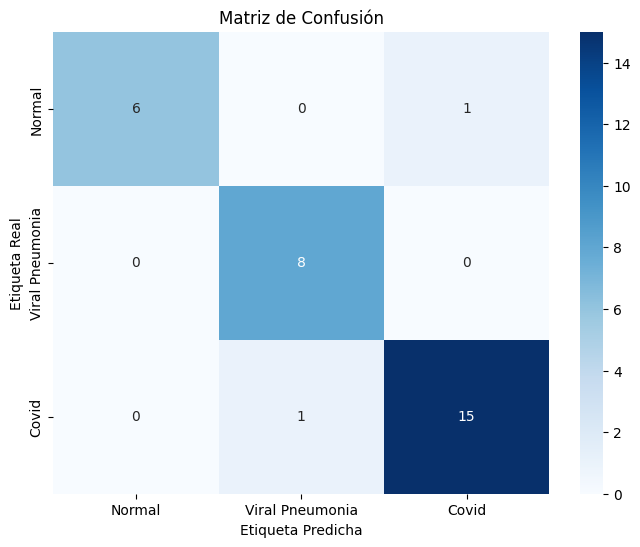

                 precision    recall  f1-score   support

         Normal       1.00      0.86      0.92         7
Viral Pneumonia       0.89      1.00      0.94         8
          Covid       0.94      0.94      0.94        16

       accuracy                           0.94        31
      macro avg       0.94      0.93      0.93        31
   weighted avg       0.94      0.94      0.94        31

1/1 [==============================] - 0s 78ms/step - loss: 0.3708 - accuracy: 0.9355
Resultado de evaluación del modelo: [0.370831698179245, 0.9354838728904724]


In [106]:
#@title Matriz de confusion
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_testOneHot = to_categorical(y_test, num_classes=len(possible_labels))

predicciones_clase = np.argmax(predicciones, axis=1)

unique, counts = np.unique(y_test, return_counts=True)
print(f"Distribución de etiquetas en el conjunto de prueba: {dict(zip(unique, counts))}")

for i, (pred, real) in enumerate(zip(predicciones_clase, y_test)):
    print(f"Imagen {i}: Predicción -> {possible_labels[pred]}, Real -> {possible_labels[real]}")

cm = confusion_matrix(y_test, predicciones_clase)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=possible_labels, yticklabels=possible_labels)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()

print(classification_report(y_test, predicciones_clase, target_names=possible_labels))

resultado = model.evaluate(x=x_test, y=y_testOneHot)
print(f"Resultado de evaluación del modelo: {resultado}")